In [128]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib import ticker
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']	# 显示中文
plt.rcParams['axes.unicode_minus'] = False		# 显示负号

## 政策利率变动统计

In [129]:
def change_count(filename):
    df = pd.read_excel(f"../data/{filename}")
    df['时间'] = pd.to_datetime(df['时间'])
    df = df.set_index('时间')
    change_ls = []
    for col in df.columns:
        df_change = df[[col]].dropna().copy()
        df_change['change'] = (df_change[col] > (df_change[col].shift(1))).astype(int) - (df_change[col] < (df_change[col].shift(1))).astype(int)
        df_change = df_change.sort_index().loc['2005-01-01':'2022-07-01']
        change_ls.append(df_change)
    return change_ls

In [130]:
filename_dic = {
    'SLO': 'SLO投放利率.xlsx',
    '存款准备金': '中国_人民币存款准备金率_大型存款类金融机构(变动公告日期).xlsx',
    '超额准备金': '中国_人民银行对金融机构存款利率_超额准备金.xlsx',
    '再贴现': '中国_人民银行对金融机构贷款利率_再贴现利率.xlsx',
    '再贷款': '中国_人民银行对金融机构贷款利率_支农、支小再贷款_1年.xlsx',
    'TMLF': '中国_定向中期借贷便利(TMLF)_利率.xlsx',
    'SLF': '中国_常备借贷便利(SLF)利率_隔夜.xlsx',
    'LPR': '中国_贷款市场报价利率(LPR)_1年.xlsx',
    'MLF': '中期借贷便利(MLF)_利率_3个月.xlsx',
    '存款基准': '存款基准利率.xlsx',
    '贷款基准': '贷款基准利率.xlsx',
    '逆回购': '逆回购利率_7天.xlsx',
}

time_dict = {
    "短期政策利率工具": ['SLO', 'SLF', '逆回购', '超额准备金'],
    "中期政策利率工具": ['存款基准', '贷款基准', 'MLF', 'LPR'],
    "央行定向工具": ['再贴现', '再贷款', 'TMLF'],
    "准备金率": ['存款准备金'],
}

default_change_count_dict = {
    '生准加息': 148,
    '降准减息': 169,
    '短期政策利率工具': 109,
    '准备金率': 107,
    '央行定向工具': 10,
    '中期政策利率工具': 91
}

In [131]:
# 统计变化
change_dict = {}
for ll in filename_dic:
    change_dict[ll] = change_count(filename_dic[ll])

In [132]:
# 数据概览
for ll in change_dict:
    print(ll)
    for lli in change_dict[ll]:
        print('\t', lli.columns[0])

SLO
	 SLO投放利率
存款准备金
	 中国:人民币存款准备金率:大型存款类金融机构(变动公告日期)
	 中国:人民币存款准备金率:中小型存款类金融机构(变动公告日期)
超额准备金
	 中国:人民银行对金融机构存款利率:超额准备金-公告
再贴现
	 中国:人民银行对金融机构贷款利率:再贴现利率
再贷款
	 中国:人民银行对金融机构贷款利率:支农、支小再贷款:1年
	 中国:人民银行对金融机构贷款利率:支农、支小再贷款:3个月
	 中国:人民银行对金融机构贷款利率:支农、支小再贷款:6个月
TMLF
	 中国:定向中期借贷便利(TMLF):利率
SLF
	 中国:常备借贷便利(SLF)利率:隔夜
	 中国:常备借贷便利(SLF)利率:7天
	 中国:常备借贷便利(SLF)利率:1个月
LPR
	 中国:贷款市场报价利率(LPR):1年
	 中国:贷款市场报价利率(LPR):5年
MLF
	 中期借贷便利(MLF):利率:3个月
	 中期借贷便利(MLF):利率:6个月
	 中期借贷便利(MLF):利率:1年
存款基准
	 一年
贷款基准
	 六个月至一年（含一年）
逆回购
	 逆回购利率:7天
	 逆回购利率:14天
	 逆回购利率:28天


In [133]:
change_count_dict = defaultdict(int)
up_set = set()
down_set = set()
up_list = []
down_list = []
for ll in change_dict:
    for lli in change_dict[ll]:
        change_count_dict['生准加息'] += (lli['change']==1).sum()
        up_set = up_set.union(set(lli[lli['change']==1].index))
        up_list.extend(lli[lli['change']==1].index.tolist())
        change_count_dict['降准减息'] += (lli['change']==-1).sum()
        down_set = down_set.union(set(lli[lli['change']==-1].index))
        down_list.extend(lli[lli['change']==-1].index.tolist())
        
        for cls in time_dict:
            if ll in time_dict[cls]:
                change_count_dict[cls] += (abs(lli['change'])==1).sum()
                break

In [134]:
for label in change_count_dict:
    yw = default_change_count_dict[label]
    fx = change_count_dict[label]
    print(f'原文{label}改变{yw}次，复现改变{fx}次，缺少{yw-fx}次')

print(f'总计来看，共降息降准{len(down_set)}次，共升息加准{len(up_set)}次')

原文生准加息改变148次，复现改变149次，缺少-1次
原文降准减息改变169次，复现改变168次，缺少1次
原文短期政策利率工具改变109次，复现改变114次，缺少-5次
原文准备金率改变107次，复现改变102次，缺少5次
原文央行定向工具改变10次，复现改变9次，缺少1次
原文中期政策利率工具改变91次，复现改变92次，缺少-1次
总计来看，共降息降准110次，共升息加准85次


In [135]:
for cls in time_dict:
    print(cls)
    for ll in time_dict[cls]:
        for lli in change_dict[ll]:
            print('\t', lli.columns[0], "升", (lli['change']==1).sum())
            print('\t', lli.columns[0], "降", (lli['change']==-1).sum())

短期政策利率工具
	 SLO投放利率 升 12
	 SLO投放利率 降 9
	 中国:常备借贷便利(SLF)利率:隔夜 升 4
	 中国:常备借贷便利(SLF)利率:隔夜 降 5
	 中国:常备借贷便利(SLF)利率:7天 升 4
	 中国:常备借贷便利(SLF)利率:7天 降 5
	 中国:常备借贷便利(SLF)利率:1个月 升 4
	 中国:常备借贷便利(SLF)利率:1个月 降 3
	 逆回购利率:7天 升 9
	 逆回购利率:7天 降 21
	 逆回购利率:14天 升 11
	 逆回购利率:14天 降 16
	 逆回购利率:28天 升 6
	 逆回购利率:28天 降 2
	 中国:人民银行对金融机构存款利率:超额准备金-公告 升 0
	 中国:人民银行对金融机构存款利率:超额准备金-公告 降 3
中期政策利率工具
	 一年 升 12
	 一年 降 12
	 六个月至一年（含一年） 升 13
	 六个月至一年（含一年） 降 13
	 中期借贷便利(MLF):利率:3个月 升 0
	 中期借贷便利(MLF):利率:3个月 降 1
	 中期借贷便利(MLF):利率:6个月 升 2
	 中期借贷便利(MLF):利率:6个月 降 3
	 中期借贷便利(MLF):利率:1年 升 4
	 中期借贷便利(MLF):利率:1年 降 5
	 中国:贷款市场报价利率(LPR):1年 升 6
	 中国:贷款市场报价利率(LPR):1年 降 16
	 中国:贷款市场报价利率(LPR):5年 升 0
	 中国:贷款市场报价利率(LPR):5年 降 5
央行定向工具
	 中国:人民银行对金融机构贷款利率:再贴现利率 升 2
	 中国:人民银行对金融机构贷款利率:再贴现利率 降 3
	 中国:人民银行对金融机构贷款利率:支农、支小再贷款:1年 升 0
	 中国:人民银行对金融机构贷款利率:支农、支小再贷款:1年 降 1
	 中国:人民银行对金融机构贷款利率:支农、支小再贷款:3个月 升 0
	 中国:人民银行对金融机构贷款利率:支农、支小再贷款:3个月 降 1
	 中国:人民银行对金融机构贷款利率:支农、支小再贷款:6个月 升 0
	 中国:人民银行对金融机构贷款利率:支农、支小再贷款:6个月 降 1
	 中国:定向中期借贷便利(TMLF):利率 升 0
	 中国:定向中期借贷便利(TML

In [136]:
up_and_down_set = up_set.intersection(down_set)
for time in up_and_down_set:
    print(time)
    for ll in change_dict:
        for lli in change_dict[ll]:
            if time in lli.index:
                idx = lli.index.get_loc(time)
                print(lli.iloc[idx-1:idx+2, :])

2012-07-03 00:00:00
            逆回购利率:7天  change
时间                          
2012-05-10      3.30      -1
2012-07-03      3.95       1
2012-07-05      3.80      -1
            逆回购利率:14天  change
时间                           
2012-06-28       4.15      -1
2012-07-03       4.10      -1
2012-07-05       4.00      -1
2018-04-17 00:00:00
            中国:人民币存款准备金率:大型存款类金融机构(变动公告日期)  change
时间                                                
2016-02-29                            17.0      -1
2018-04-17                            16.0      -1
2018-06-24                            15.5      -1
            中国:人民币存款准备金率:中小型存款类金融机构(变动公告日期)  change
时间                                                 
2016-02-29                             15.0      -1
2018-04-17                             14.0      -1
2018-06-24                             13.5      -1
            中国:贷款市场报价利率(LPR):1年  change
时间                                     
2018-04-16                 4.31       0
2018-04-17                 4.3

2014-11-28:  SLO提高；LPR降低

2018-04-17:  存款准备金_大型降低；存款准备金_中小型降低；MLF提高；LPR不变

2012-07-03:  逆回购_7天提高；逆回购_14天降低

In [137]:
up_set = up_set.difference({pd.Timestamp('2014-11-28 00:00:00'), pd.Timestamp('2018-04-17 00:00:00'), pd.Timestamp('2012-07-03 00:00:00')})
down_set = down_set.difference({pd.Timestamp('2014-11-28 00:00:00'), pd.Timestamp('2018-04-17 00:00:00'), pd.Timestamp('2012-07-03 00:00:00')})
len(up_set), len(down_set)

(82, 107)

## 可投资资产数据

In [138]:
stock_index = pd.read_csv("../data/hs300.csv")
stock_index['DateTime'] = pd.to_datetime(stock_index['DateTime'])
stock_index = stock_index.set_index('DateTime')
stock_index['return'] = stock_index['CLOSE'].pct_change(1)
stock_index['cum_return'] = (stock_index['return']+1).cumprod()

<Axes: xlabel='DateTime'>

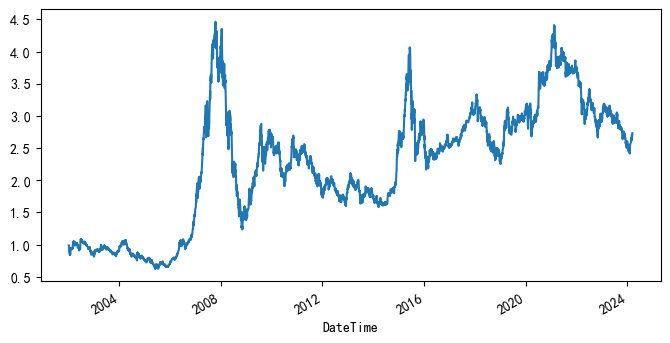

In [139]:
stock_index['cum_return'].plot(figsize=(8,4))

In [140]:
# 中债国债1-3年净价总指数

bond_index = pd.read_csv("../data/CBA.csv")
bond_index['DateTime'] = pd.to_datetime(bond_index['DateTime'])
bond_index = bond_index.set_index('DateTime')
bond_index['return'] = bond_index['CLOSE'].pct_change(1)
bond_index['cum_return'] = (bond_index['return']+1).cumprod()

<Axes: xlabel='DateTime'>

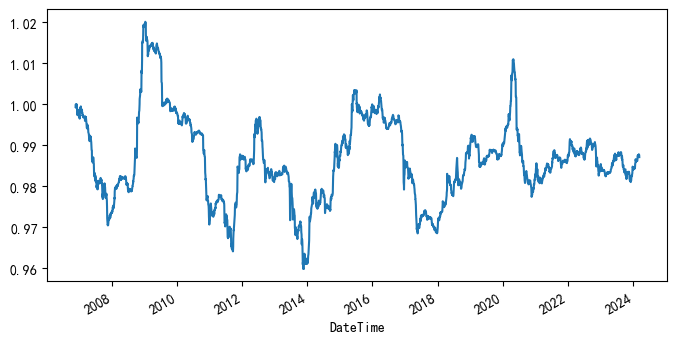

In [141]:
bond_index['cum_return'].plot(figsize=(8,4))

In [142]:
stock_index2 = pd.read_csv("../data/zz500.csv")
stock_index2['DateTime'] = pd.to_datetime(stock_index2['DateTime'])
stock_index2 = stock_index2.set_index('DateTime')
stock_index2['return'] = stock_index2['CLOSE'].pct_change(1)
stock_index2['cum_return'] = (stock_index2['return']+1).cumprod()

<Axes: xlabel='DateTime'>

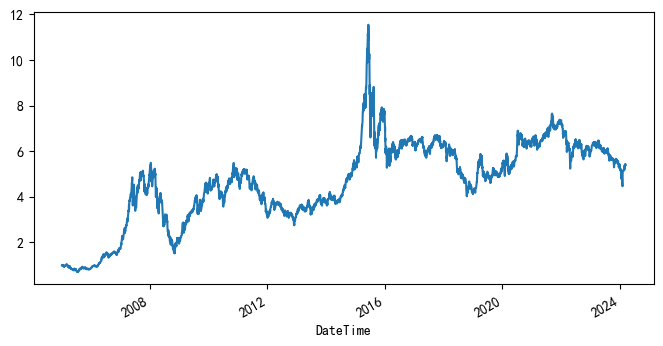

In [143]:
stock_index2['cum_return'].plot(figsize=(8,4))

## 政策事件法分析

In [144]:
def cal_cum_return(asset_return, change_time):
    try:
        if change_time < asset_return.index[0]:
            print(f'政策变化时间为{change_time.strftime("%Y-%m-%d")},指数数据未覆盖')
            return None
        if change_time not in asset_return.index:
            return cal_cum_return(asset_return, change_time+pd.Timedelta(days=1))
        time_idx = asset_return.index.get_loc(change_time)
        tmp_return_df = asset_return.iloc[time_idx-10:time_idx+61].copy()
        tmp_return_df['cum_return'] = tmp_return_df['cum_return'] / tmp_return_df.iloc[10]['cum_return']
        tmp_return_df = tmp_return_df[['cum_return']].reset_index(drop=True)
        return tmp_return_df
    except:
        print(change_time)


In [145]:
up_stock_cum_returns = []
up_bond_cum_returns = []
down_stock_cum_returns = []
down_bond_cum_returns = []

for up_time in up_set:
    stock_cum_return = cal_cum_return(stock_index, up_time)
    up_stock_cum_returns.append(stock_cum_return)
    bond_cum_return = cal_cum_return(bond_index, up_time)
    up_bond_cum_returns.append(bond_cum_return)
    
for down_time in down_set:
    stock_cum_return = cal_cum_return(stock_index, down_time)
    down_stock_cum_returns.append(stock_cum_return)
    bond_cum_return = cal_cum_return(bond_index, down_time)
    down_bond_cum_returns.append(bond_cum_return)

政策变化时间为2006-07-21,指数数据未覆盖
政策变化时间为2006-01-24,指数数据未覆盖
政策变化时间为2005-02-06,指数数据未覆盖
政策变化时间为2006-04-28,指数数据未覆盖
政策变化时间为2006-08-19,指数数据未覆盖
政策变化时间为2006-11-03,指数数据未覆盖
政策变化时间为2006-06-16,指数数据未覆盖
政策变化时间为2005-03-17,指数数据未覆盖


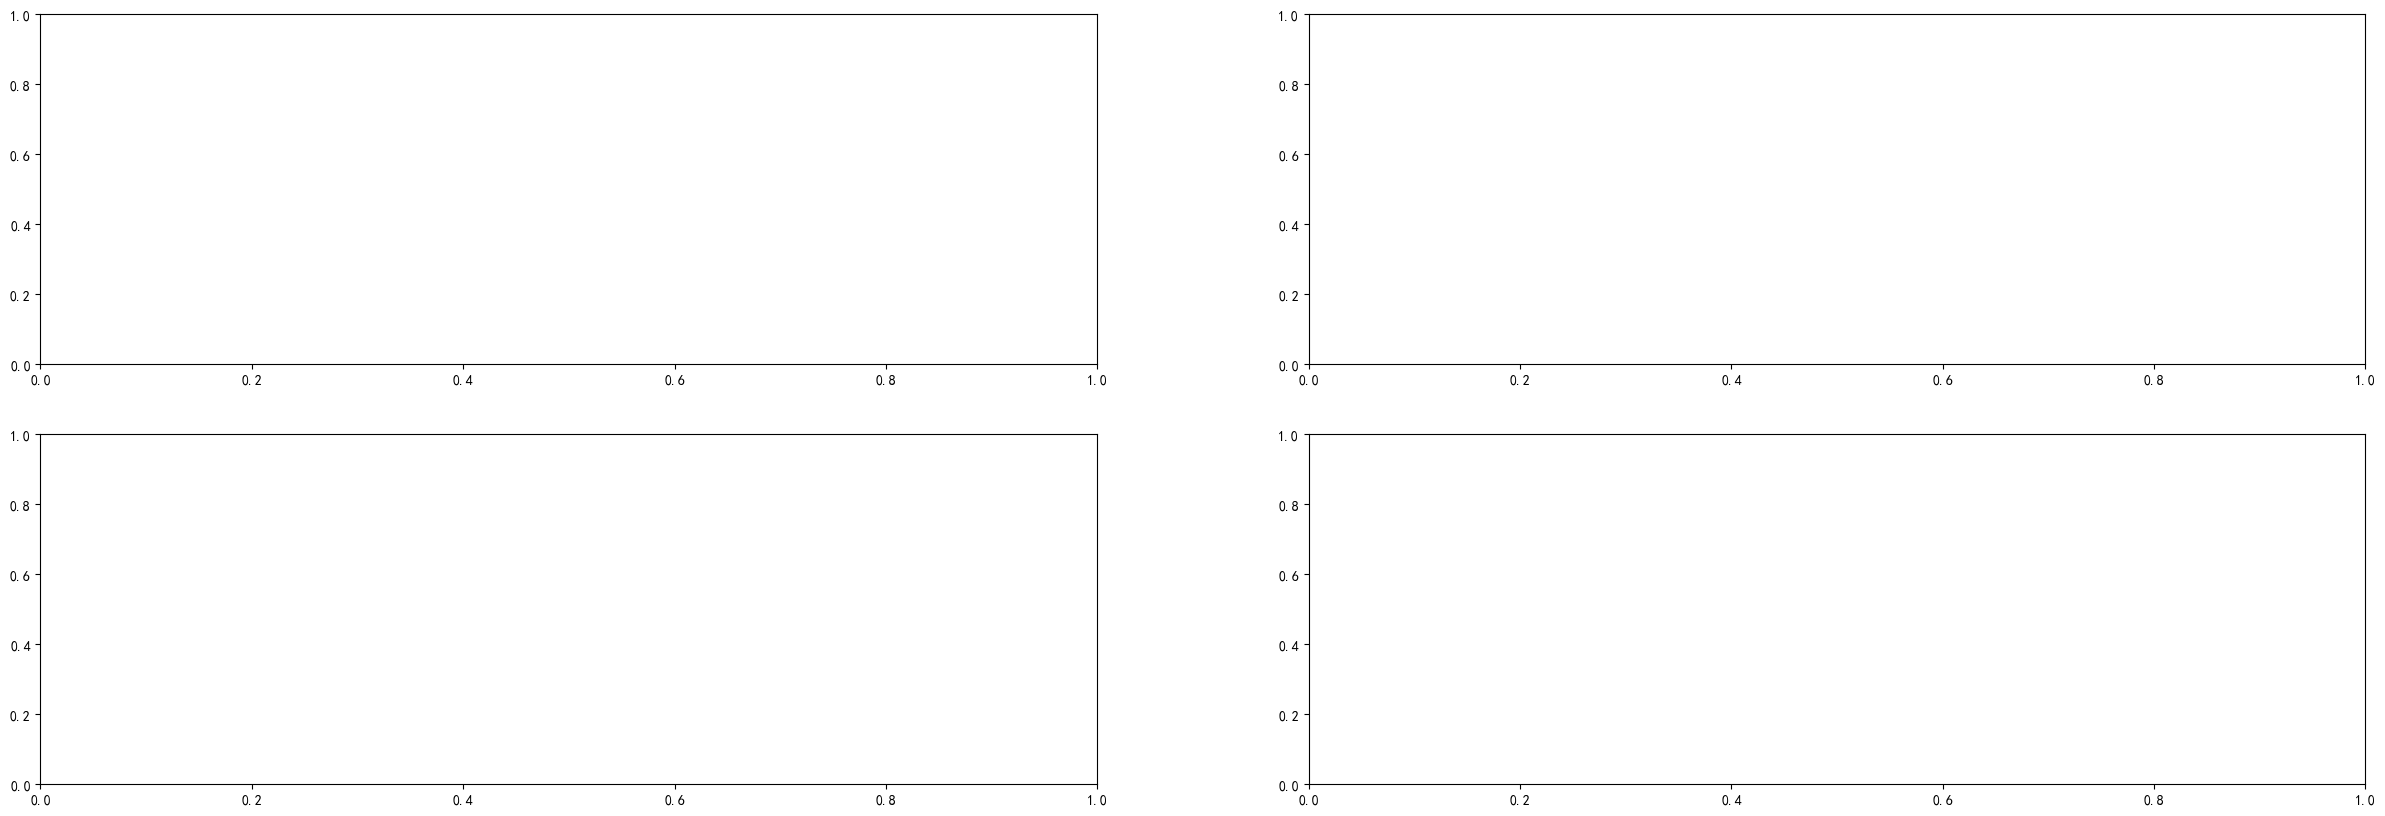

In [146]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(30, 10))

In [147]:
a = pd.concat(up_stock_cum_returns).reset_index().groupby('index')[['cum_return']] \
    .mean().rename(columns={'cum_return': '升息加准:股票后续表现'})
b = pd.concat(down_stock_cum_returns).reset_index().groupby('index')[['cum_return']] \
    .mean().rename(columns={'cum_return': '降息降准:股票后续表现'})
stock_return = pd.concat([a, b], axis=1)-1

stock_return.index.name = '天数'
stock_return.index = stock_return.index-10

stock_return.plot(ax=ax1, color=('#ffc000', '#001f5f'))
ax1.vlines(0, -0.02, 0.08, linestyles='-', colors='gray')
ax1.hlines(0, -10, 60, linestyles='-', colors='gray')

ax1.set_ylim((-0.02, 0.08))
ax1.set_xlim((-10, 60))
ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

In [148]:
a = pd.concat(up_bond_cum_returns).reset_index().groupby('index')[['cum_return']] \
    .mean().rename(columns={'cum_return': '升息加准:债券后续表现'})
b = pd.concat(down_bond_cum_returns).reset_index().groupby('index')[['cum_return']] \
    .mean().rename(columns={'cum_return': '降息降准:债券后续表现'})
bond_return = pd.concat([a, b], axis=1)-1

bond_return.index.name = '天数'
bond_return.index = bond_return.index-10

bond_return.plot(ax=ax2, color=('#ffc000', '#001f5f'))
ax2.vlines(0, -0.003, 0.002, linestyles='-', colors='gray')
ax2.hlines(0, -10, 60, linestyles='-', colors='gray')

ax2.set_ylim((-0.003, 0.002))
ax2.set_xlim((-10, 60))
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))

In [192]:
def check_change_time(asset_return, change_time):
    if change_time < asset_return.index[0]:
        print(f'政策变化时间为{change_time.strftime("%Y-%m-%d")},指数数据未覆盖')
        return None
    if change_time not in asset_return.index:
        return check_change_time(asset_return, change_time+pd.Timedelta(days=1))
    return change_time

def cal_strategy_return(asset_return, change_times, N, r=0):
    asset_return = asset_return.copy()
    mod_change_times = []
    for change_time in change_times:
        change_time = check_change_time(asset_return, change_time)
        if not change_time is None:
            mod_change_times.append(change_time)
    asset_return.loc[mod_change_times, '事件'] = 1
    asset_return = asset_return.ffill(limit=N)
    asset_return['strategy'] = asset_return['事件']*asset_return['return'].shift(-1)
    asset_return['strategy'] = asset_return['strategy'].replace(np.nan, r)
    asset_return['strategy'] = (asset_return['strategy']+1).cumprod()
    
    return asset_return['strategy']

In [150]:
stock_strategy_return = pd.DataFrame(index=stock_index.index)
stock_strategy_return.index.name = '时间'
stock_strategy_return['加息升准：股票策略走势'] = cal_strategy_return(stock_index, up_set, 60)
stock_strategy_return['降息降准：股票策略走势'] = cal_strategy_return(stock_index, down_set, 60)
stock_strategy_return[['降息降准：股票策略走势','加息升准：股票策略走势']].plot(ax=ax3, color=('#001f5f', '#ffc000'))

ax3.set_ylim((0, 6))
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.1f'))


In [151]:
bond_strategy_return = pd.DataFrame(index=bond_index.index)
bond_strategy_return.index.name = '时间'
bond_strategy_return['加息升准：国债策略走势'] = cal_strategy_return(bond_index, up_set, 60)
bond_strategy_return['降息降准：国债策略走势'] = cal_strategy_return(bond_index, down_set, 60)
bond_strategy_return[['降息降准：国债策略走势','加息升准：国债策略走势']].plot(ax=ax4, color=('#001f5f', '#ffc000'))

ax4.set_ylim((0.9, 1.1))
ax4.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f'))

政策变化时间为2006-07-21,指数数据未覆盖
政策变化时间为2006-01-24,指数数据未覆盖
政策变化时间为2005-02-06,指数数据未覆盖
政策变化时间为2006-04-28,指数数据未覆盖
政策变化时间为2006-08-19,指数数据未覆盖
政策变化时间为2006-11-03,指数数据未覆盖
政策变化时间为2006-06-16,指数数据未覆盖
政策变化时间为2005-03-17,指数数据未覆盖


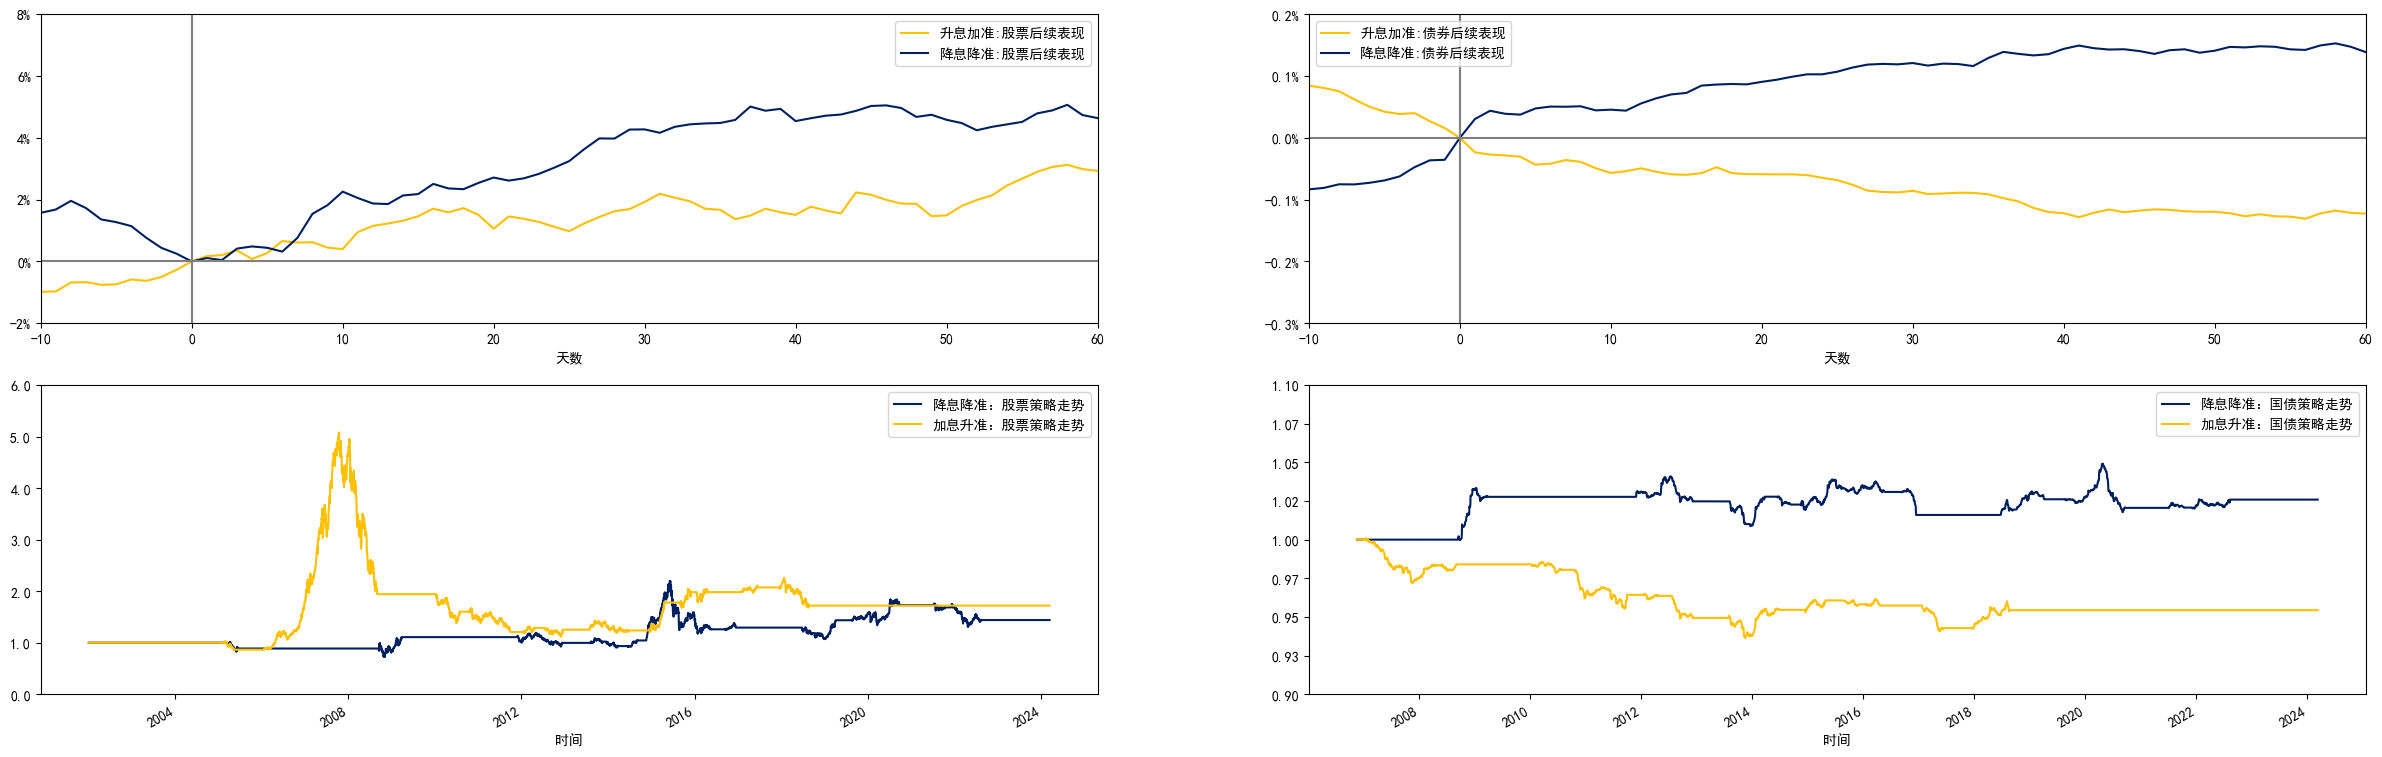

In [152]:
fig

## 市场利率法

In [153]:
shibor = pd.read_excel('../data/SHIBOR1W.xlsx')
shibor['时间'] = pd.to_datetime(shibor['时间'])
shibor = shibor.set_index('时间')
shibor1w = shibor[['SHIBOR1W']].copy()
shibor3m = shibor[['SHIBOR3M']].copy()

r007 = pd.read_excel('../data/R007.xlsx')
r007['时间'] = pd.to_datetime(r007['时间'])
dr007 = r007[['DR007']].copy()
r007 = r007[['R007']].copy()

In [154]:
change_time_set = up_set.union(down_set)
len(up_set), len(down_set), len(change_time_set)

(82, 107, 189)

In [155]:
ease_time_set = set()
tightening_time_set = set()

for change_time in up_list+down_list:
    change_time = check_change_time(shibor1w, change_time)
    if change_time is None:
        continue
    change_time_idx = shibor1w.index.get_loc(change_time)
    range_shibor1w = shibor1w.iloc[change_time_idx-1:change_time_idx+2,:]
    delta_shibor = range_shibor1w.iloc[-1,0] - range_shibor1w.iloc[0,0]
    if delta_shibor > 0:
        tightening_time_set.add(change_time)
        change_count_dict['tightening_time'] += 1
    elif delta_shibor < 0:
        ease_time_set.add(change_time)
        change_count_dict['ease_time'] += 1

政策变化时间为2006-06-16,指数数据未覆盖
政策变化时间为2006-07-21,指数数据未覆盖
政策变化时间为2006-06-16,指数数据未覆盖
政策变化时间为2006-07-21,指数数据未覆盖
政策变化时间为2006-08-19,指数数据未覆盖
政策变化时间为2006-04-28,指数数据未覆盖
政策变化时间为2006-08-19,指数数据未覆盖
政策变化时间为2005-02-06,指数数据未覆盖
政策变化时间为2006-01-24,指数数据未覆盖
政策变化时间为2005-03-17,指数数据未覆盖


In [156]:
print(f"原文超预期宽松150次，复现{change_count_dict['ease_time']}次，缺少{150-change_count_dict['ease_time']}次")
print(f"原文超预期紧缩166次，复现{change_count_dict['tightening_time']}次，缺少{166-change_count_dict['tightening_time']}次")

原文超预期宽松150次，复现153次，缺少-3次
原文超预期紧缩166次，复现153次，缺少13次


In [157]:
len(ease_time_set), len(tightening_time_set)

(88, 91)

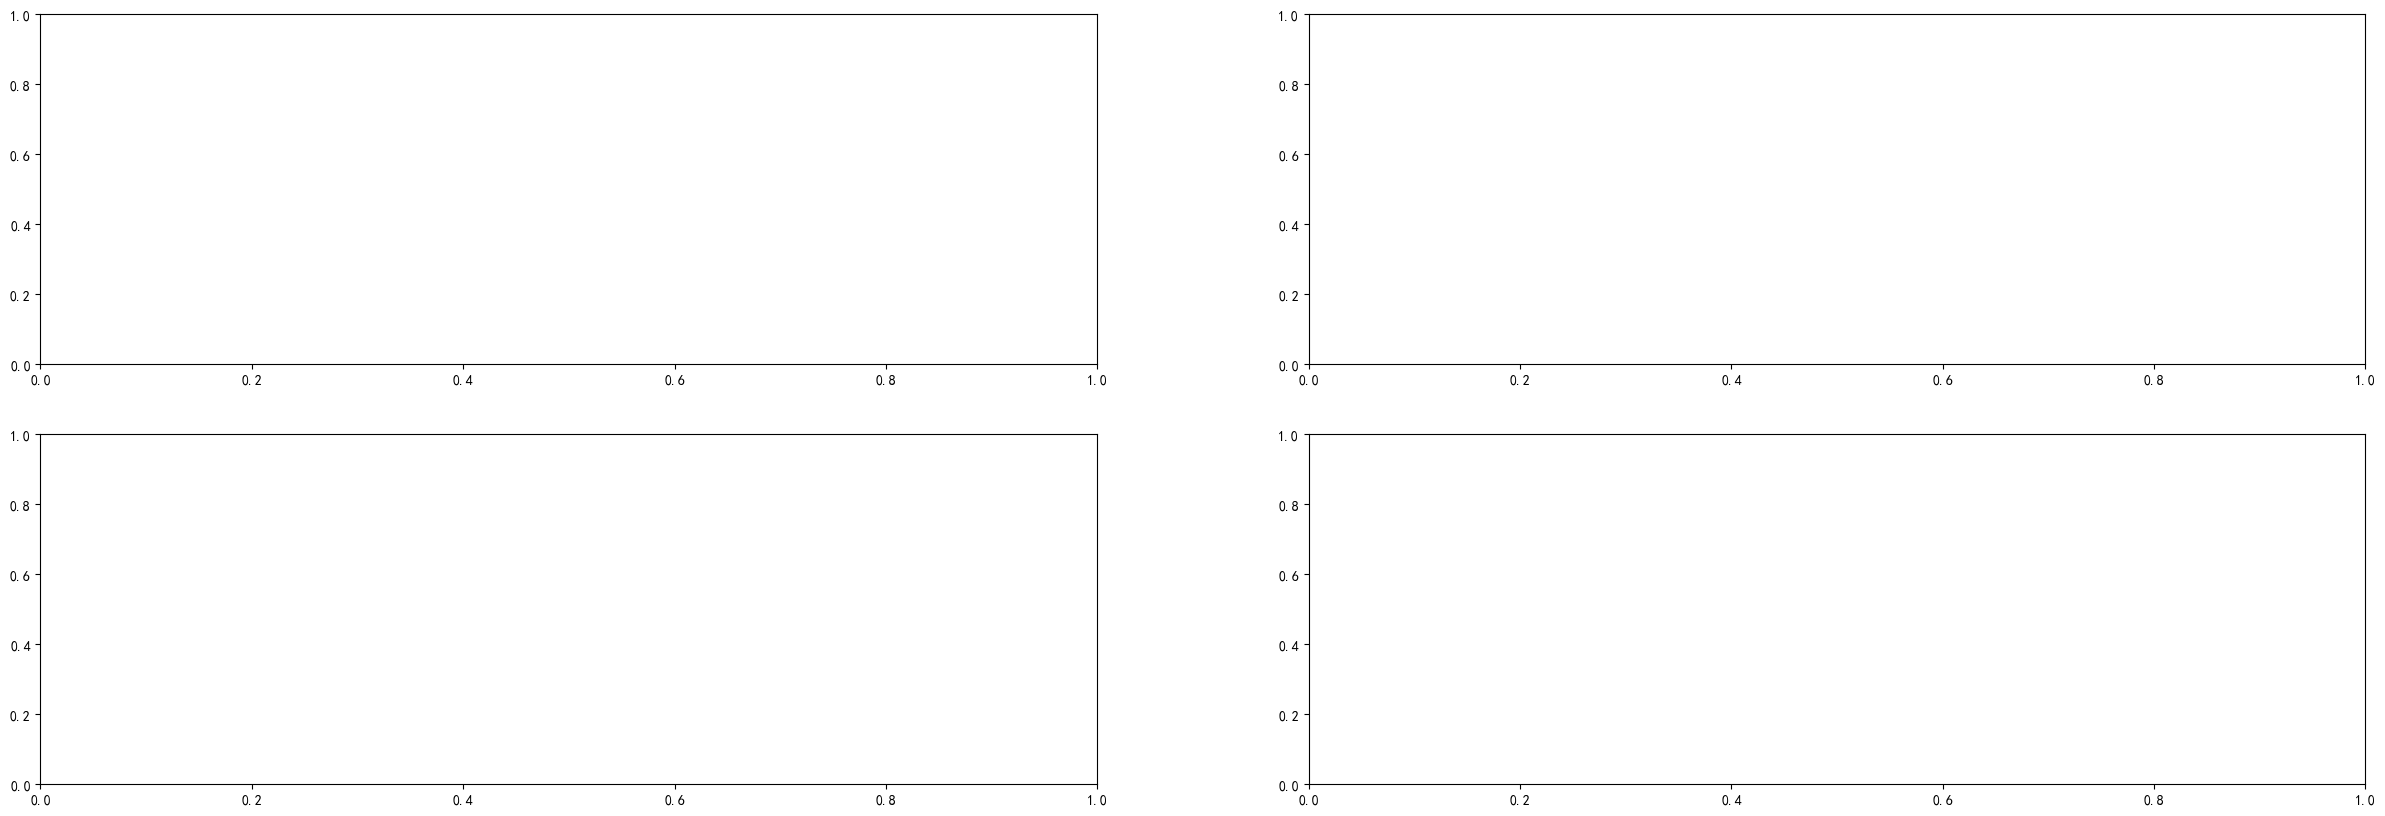

In [168]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(30, 10))

In [169]:
up_stock_cum_returns = []
up_bond_cum_returns = []
down_stock_cum_returns = []
down_bond_cum_returns = []

for up_time in tightening_time_set:
    stock_cum_return = cal_cum_return(stock_index, up_time)
    up_stock_cum_returns.append(stock_cum_return)
    bond_cum_return = cal_cum_return(bond_index, up_time)
    up_bond_cum_returns.append(bond_cum_return)
    
for down_time in ease_time_set:
    stock_cum_return = cal_cum_return(stock_index, down_time)
    down_stock_cum_returns.append(stock_cum_return)
    bond_cum_return = cal_cum_return(bond_index, down_time)
    down_bond_cum_returns.append(bond_cum_return)

政策变化时间为2006-11-03,指数数据未覆盖


In [170]:
a = pd.concat(up_stock_cum_returns).reset_index().groupby('index')[['cum_return']] \
    .mean().rename(columns={'cum_return': '升息加准:股票后续表现'})
b = pd.concat(down_stock_cum_returns).reset_index().groupby('index')[['cum_return']] \
    .mean().rename(columns={'cum_return': '降息降准:股票后续表现'})
stock_return = pd.concat([a, b], axis=1)-1

stock_return.index.name = '天数'
stock_return.index = stock_return.index-10

stock_return.plot(ax=ax1, color=('#ffc000', '#001f5f'))
ax1.vlines(0, -0.02, 0.08, linestyles='-', colors='gray')
ax1.hlines(0, -10, 60, linestyles='-', colors='gray')

ax1.set_ylim((-0.02, 0.08))
ax1.set_xlim((-10, 60))
ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))


In [171]:
a = pd.concat(up_bond_cum_returns).reset_index().groupby('index')[['cum_return']] \
    .mean().rename(columns={'cum_return': '升息加准:债券后续表现'})
b = pd.concat(down_bond_cum_returns).reset_index().groupby('index')[['cum_return']] \
    .mean().rename(columns={'cum_return': '降息降准:债券后续表现'})
bond_return = pd.concat([a, b], axis=1)-1

bond_return.index.name = '天数'
bond_return.index = bond_return.index-10

bond_return.plot(ax=ax2, color=('#ffc000', '#001f5f'))
ax2.vlines(0, -0.02, 0.02, linestyles='-', colors='gray')
ax2.hlines(0, -10, 60, linestyles='-', colors='gray')

ax2.set_ylim((-0.002, 0.002))
ax2.set_xlim((-10, 60))
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=2))

In [172]:
stock_strategy_return = pd.DataFrame(index=stock_index.index)
stock_strategy_return.index.name = '时间'
stock_strategy_return['加息升准：股票策略走势'] = cal_strategy_return(stock_index, tightening_time_set, 20)
stock_strategy_return['降息降准：股票策略走势'] = cal_strategy_return(stock_index, ease_time_set, 20)
stock_strategy_return[['降息降准：股票策略走势','加息升准：股票策略走势']].plot(ax=ax3, color=('#001f5f', '#ffc000'))

ax3.set_ylim((0, 6))
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.1f'))

In [173]:
bond_strategy_return = pd.DataFrame(index=bond_index.index)
bond_strategy_return.index.name = '时间'
bond_strategy_return['加息升准：国债策略走势'] = cal_strategy_return(bond_index, tightening_time_set, 20)
bond_strategy_return['降息降准：国债策略走势'] = cal_strategy_return(bond_index, ease_time_set, 20)
bond_strategy_return[['降息降准：国债策略走势','加息升准：国债策略走势']].plot(ax=ax4, color=('#001f5f', '#ffc000'))

ax4.set_ylim((0.9, 1.1))
ax4.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f'))

政策变化时间为2006-11-03,指数数据未覆盖


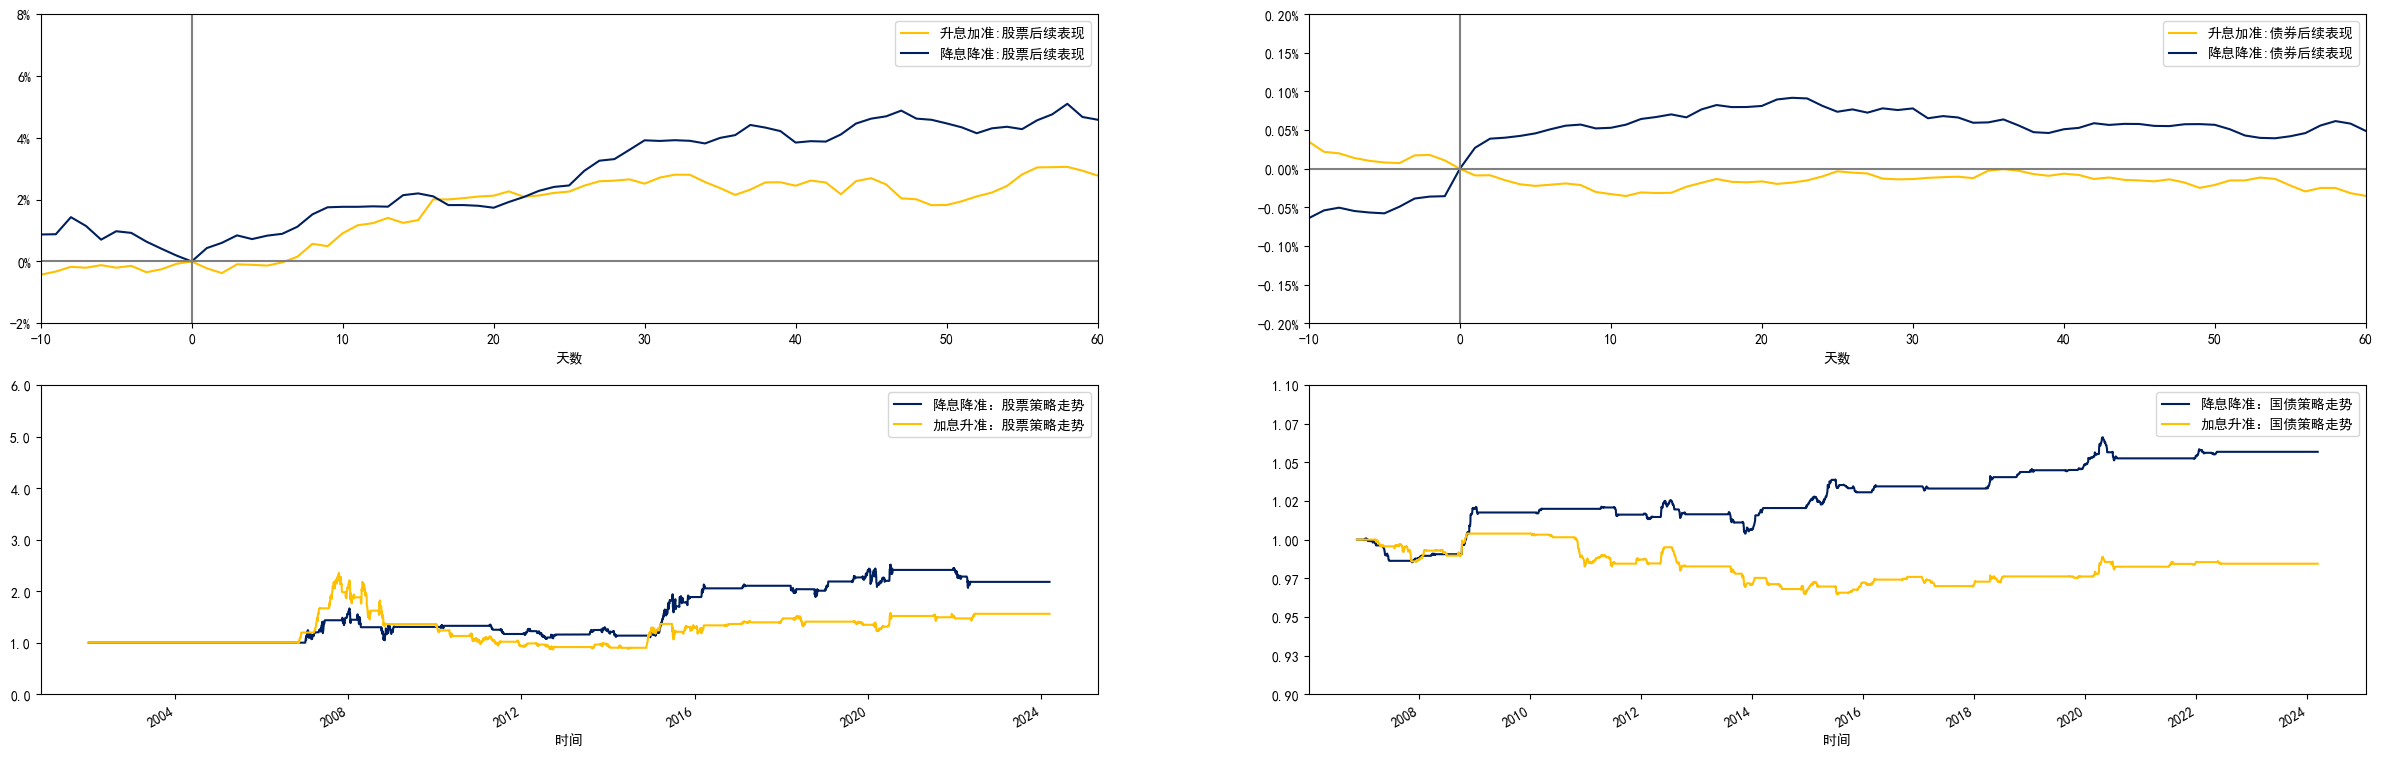

In [174]:
fig

## 两法结合

In [195]:
down_ease_time_set = ease_time_set.intersection(down_set)
up_tightening_time_set = up_set.intersection(tightening_time_set)

In [196]:
len(down_ease_time_set), len(up_tightening_time_set)

(54, 37)

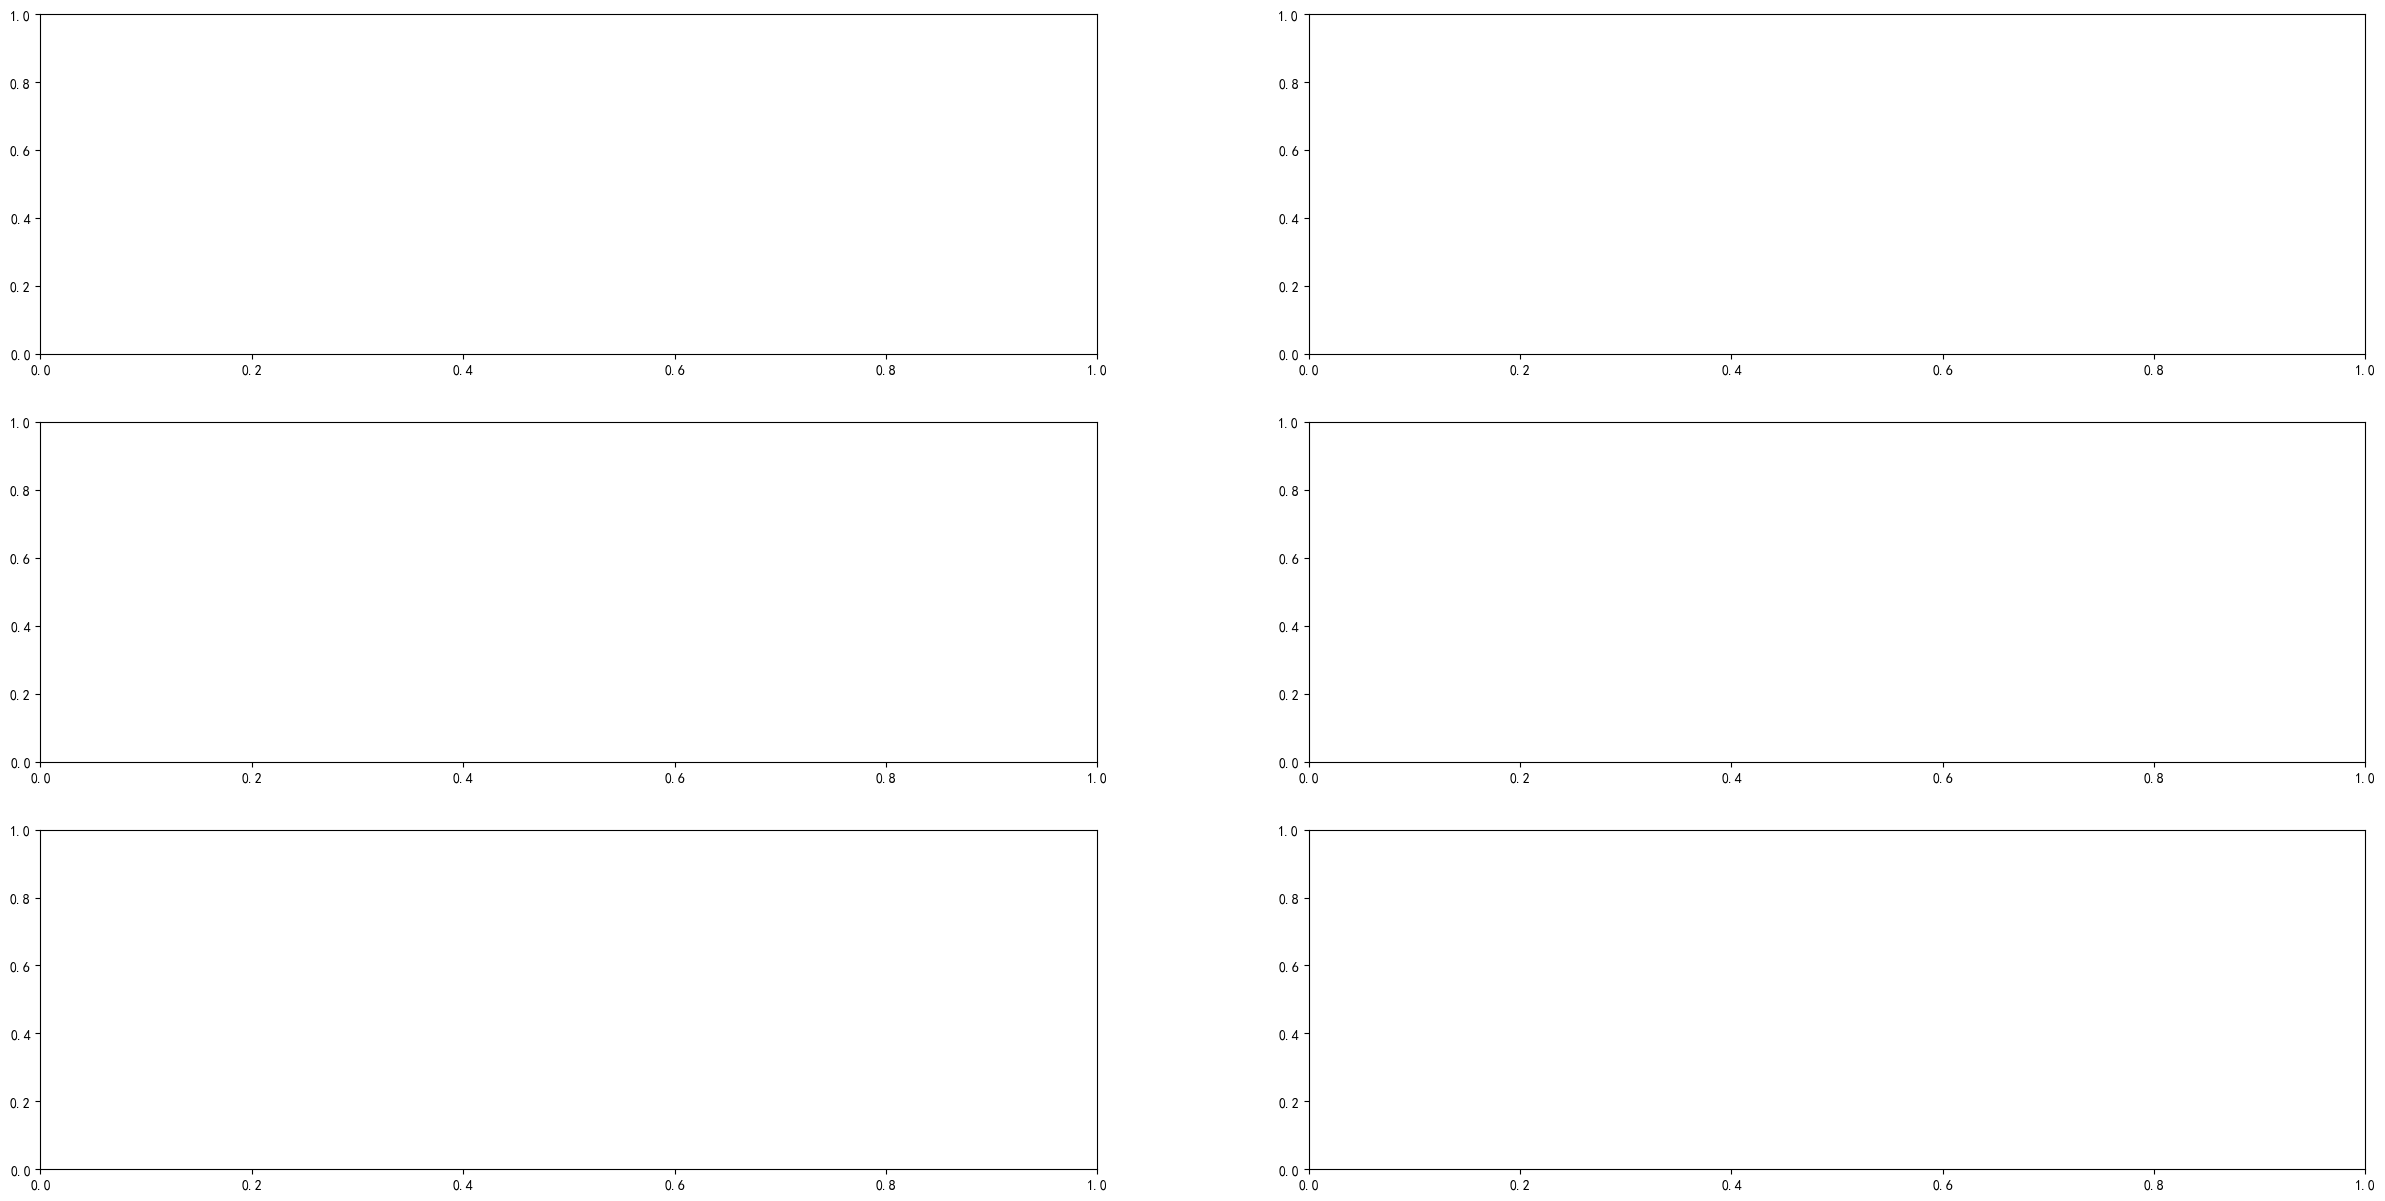

In [217]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(30, 15))

In [218]:
up_tightening_stock_cum_returns = []
up_tightening_stock_cum_returns2 = []
up_tightening_bond_cum_returns = []
down_ease_stock_cum_returns = []
down_ease_stock_cum_returns2 = []
down_ease_bond_cum_returns = []

for up_time in up_tightening_time_set:
    stock_cum_return = cal_cum_return(stock_index, up_time)
    up_tightening_stock_cum_returns.append(stock_cum_return)
    
    stock_cum_return2 = cal_cum_return(stock_index2, up_time)
    up_tightening_stock_cum_returns2.append(stock_cum_return2)
    
    bond_cum_return = cal_cum_return(bond_index, up_time)
    up_tightening_bond_cum_returns.append(bond_cum_return)
    
for down_time in down_ease_time_set:
    stock_cum_return = cal_cum_return(stock_index, down_time)
    down_ease_stock_cum_returns.append(stock_cum_return)
    
    stock_cum_return2 = cal_cum_return(stock_index2, down_time)
    down_ease_stock_cum_returns2.append(stock_cum_return2)
    
    bond_cum_return = cal_cum_return(bond_index, down_time)
    down_ease_bond_cum_returns.append(bond_cum_return)

政策变化时间为2006-11-03,指数数据未覆盖


In [219]:
a = pd.concat(up_tightening_stock_cum_returns).reset_index().groupby('index')[['cum_return']] \
    .mean().rename(columns={'cum_return': '升息加准&Δshibor1w>0:沪深300后续表现'})
b = pd.concat(down_ease_stock_cum_returns).reset_index().groupby('index')[['cum_return']] \
    .mean().rename(columns={'cum_return': '降息降准&Δshibor1w<0:沪深300后续表现'})
stock_return = pd.concat([a, b], axis=1)-1

stock_return.index.name = '天数'
stock_return.index = stock_return.index-10

stock_return.plot(ax=ax1, color=('#ffc000', '#001f5f'))
ax1.vlines(0, -0.02, 0.08, linestyles='-', colors='gray')
ax1.hlines(0, -10, 60, linestyles='-', colors='gray')

ax1.set_ylim((-0.02, 0.08))
ax1.set_xlim((-10, 60))
ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))


In [220]:
a = pd.concat(up_tightening_stock_cum_returns2).reset_index().groupby('index')[['cum_return']] \
    .mean().rename(columns={'cum_return': '升息加准&Δshibor1w>0:中证500后续表现'})
b = pd.concat(down_ease_stock_cum_returns2).reset_index().groupby('index')[['cum_return']] \
    .mean().rename(columns={'cum_return': '降息降准&Δshibor1w<0:中证500后续表现'})
stock_return = pd.concat([a, b], axis=1)-1

stock_return.index.name = '天数'
stock_return.index = stock_return.index-10

stock_return.plot(ax=ax3, color=('#ffc000', '#001f5f'))
ax3.vlines(0, -0.02, 0.08, linestyles='-', colors='gray')
ax3.hlines(0, -10, 60, linestyles='-', colors='gray')

ax3.set_ylim((-0.02, 0.14))
ax3.set_xlim((-10, 60))
ax3.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))


In [221]:
a = pd.concat(up_tightening_bond_cum_returns).reset_index().groupby('index')[['cum_return']] \
    .mean().rename(columns={'cum_return': '升息加准&Δshibor1w>0:债券后续表现'})
    
b = pd.concat(down_ease_bond_cum_returns).reset_index().groupby('index')[['cum_return']] \
    .mean().rename(columns={'cum_return': '降息降准&Δshibor1w<0:债券后续表现'})
    
bond_return = pd.concat([a, b], axis=1)-1

bond_return.index.name = '天数'
bond_return.index = bond_return.index-10

bond_return.plot(ax=ax5, color=('#ffc000', '#001f5f'))
ax5.vlines(0, -0.02, 0.02, linestyles='-', colors='gray')
ax5.hlines(0, -10, 60, linestyles='-', colors='gray')

ax5.set_ylim((-0.003, 0.002))
ax5.set_xlim((-10, 60))
ax5.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=2))

In [222]:
r = 1.5/100/365

In [223]:
stock_strategy_return1 = pd.DataFrame(index=stock_index.index)
stock_strategy_return1.index.name = '时间'
stock_strategy_return1['加息升准：股票策略走势'] = cal_strategy_return(stock_index, up_tightening_time_set, 20, r)
stock_strategy_return1['降息降准：股票策略走势'] = cal_strategy_return(stock_index, down_ease_time_set, 20, r)
stock_strategy_return1[['降息降准：股票策略走势','加息升准：股票策略走势']].plot(ax=ax2, color=('#001f5f', '#ffc000'))

ax2.set_ylim((0, 6))
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.1f'))

In [224]:
stock_strategy_return2 = pd.DataFrame(index=stock_index2.index)
stock_strategy_return2.index.name = '时间'
stock_strategy_return2['加息升准：股票策略走势'] = cal_strategy_return(stock_index2, up_tightening_time_set, 20, r)
stock_strategy_return2['降息降准：股票策略走势'] = cal_strategy_return(stock_index2, down_ease_time_set, 20, r)
stock_strategy_return2[['降息降准：股票策略走势','加息升准：股票策略走势']].plot(ax=ax4, color=('#001f5f', '#ffc000'))

ax4.set_ylim((0, 6))
ax4.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.1f'))

In [227]:
bond_strategy_return = pd.DataFrame(index=bond_index.index)
bond_strategy_return.index.name = '时间'
bond_strategy_return['加息升准：国债策略走势'] = cal_strategy_return(bond_index, up_tightening_time_set, 20, r)
bond_strategy_return['降息降准：国债策略走势'] = cal_strategy_return(bond_index, down_ease_time_set, 20, r)
bond_strategy_return[['降息降准：国债策略走势','加息升准：国债策略走势']].plot(ax=ax6, color=('#001f5f', '#ffc000'))

ax6.set_ylim((0.9, 1.5))
ax6.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f'))

政策变化时间为2006-11-03,指数数据未覆盖


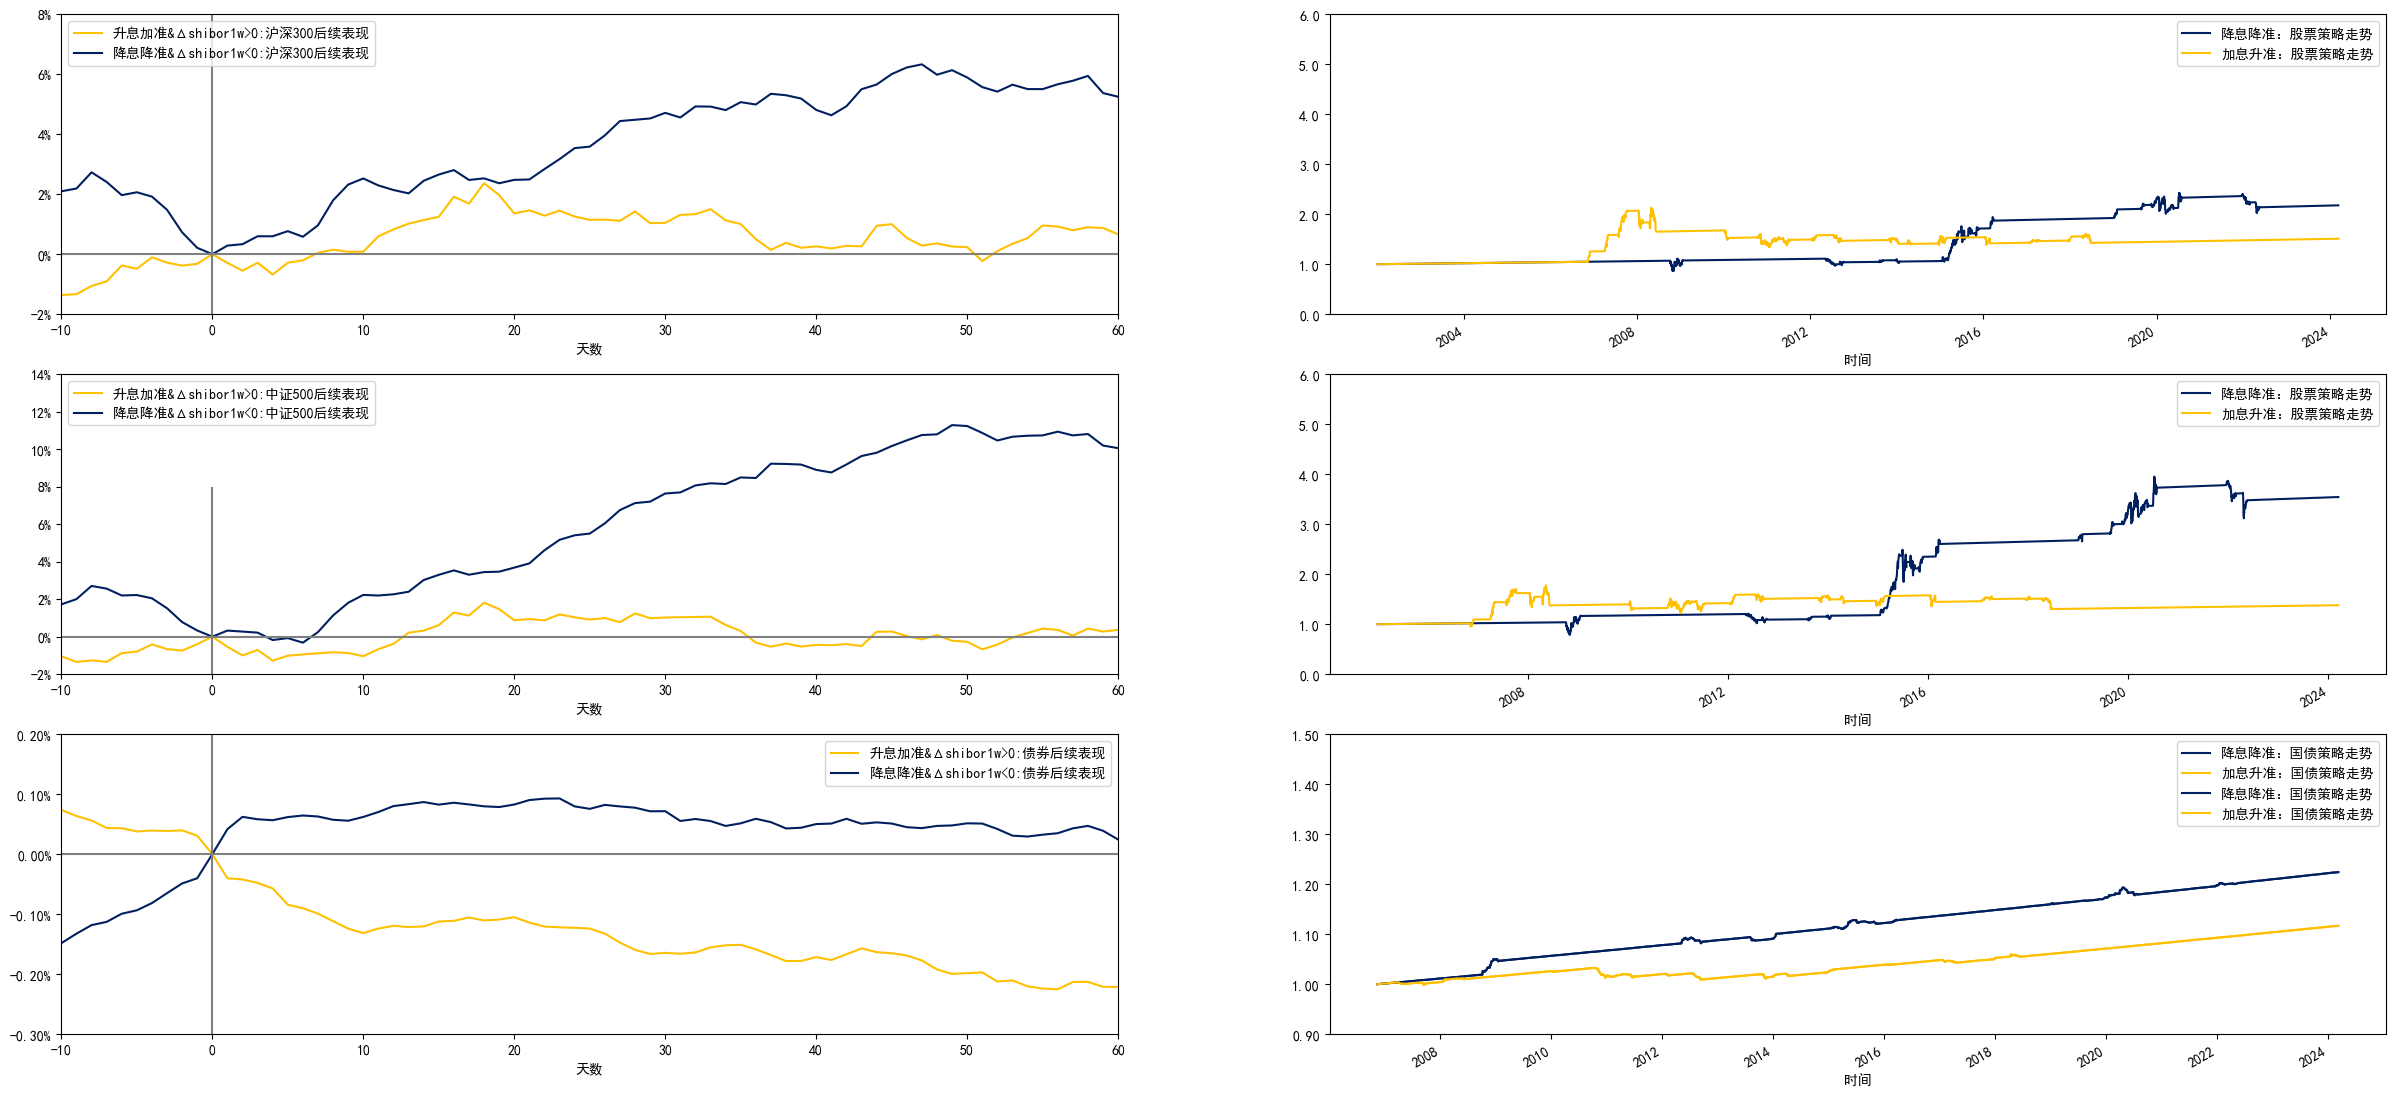

In [228]:
fig